# Code for the Numerical Studies of Relativistic Hydro

Nícolas Frazão Fernandes

This code is my attempt to make a finite volume (KT method) simulation for non-Relativistic Israel-Stewart equations in 1 dimension


Lets first apply KT method to the Zero shear limit and non zero bulk viscosity non-Relativistic IS equations in dimentionless form:

$\partial_{t} \rho + \nabla_k (\rho v_k) = 0$

$\partial_t (\rho v_i) + \frac{1}{\gamma} \nabla_k \left( \gamma \rho v_i v_k + \delta^{k}_{i} \left( c_s^2 \rho + \Pi \right) \right) = 0 $

$\partial_{t} \Pi + \nabla_k( v_k (\Pi + B) ) = -\Pi/\tau_\nu $

such that

$ \quad \quad c_s = \sqrt{\frac{\partial P}{\partial \rho}} = \sqrt{\frac{\gamma P_0  \rho^{\gamma - 1}}{\rho^{\gamma}}}$

With the equation of state being (isentropic)

$P = P_0 \left (\frac{\rho}{\rho_0} \right)^α $

$\frac{\zeta}{\tau_{\nu}} = B P_0$


In [1]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

plt.rcParams['text.usetex'] = True

In [3]:
def getConserved( rho, vx, Pi, vol ):
    """
    Calculate the conserved variable from the primitive
    rho      is matrix of cell densities
    vx       is matrix of cell x-velocity
    vol      is cell volume
    Mass     is matrix of mass in cells
    Momx     is matrix of x-momentum in cells
    """
    Mass   = rho * vol
    Momx   = rho * vx
    Pi_vx  = Pi  * vx

    return Mass, Momx, Pi_vx

In [4]:
def getPrimitive( Mass, Momx, gamma, vol):
  """
  Calculate the primitive variable from the conservative
  Mass     is matrix of mass in cells
  Momx     is matrix of x-momentum in cells
  gamma    is ideal gas gamma
  vol      is cell volume
  rho      is matrix of cell densities
  vx       is matrix of cell x-velocity
  P        is matrix of cell pressures
  """
  rho = Mass / vol
  vx  = Momx / rho
  P   = (rho)**gamma

  return rho, vx, P

In [5]:
def getSpeedOfSound(rho, gamma):

  cs = np.sqrt((gamma)*rho**(gamma-1))

  return cs


useful functions to calculate local propagation speed

$ minmod(x,y,z) \equiv \min(\mod(x,minmod(y,z))) $

$ minmod(x,y) \equiv [sgn(x) + sgn(y)] \cdot \min(|x|,|y|) /2 $

$ sgn(x) = |x|/x$

In [6]:
'''
These are auxiliary functions in for the gradient
'''

def minmod2(x,y):
  return (np.sign(x) + np.sign(y))*np.minimum(np.abs(x), np.abs(y))/2

def minmod3(x,y,z):
  return minmod2(x,minmod2(y,z))



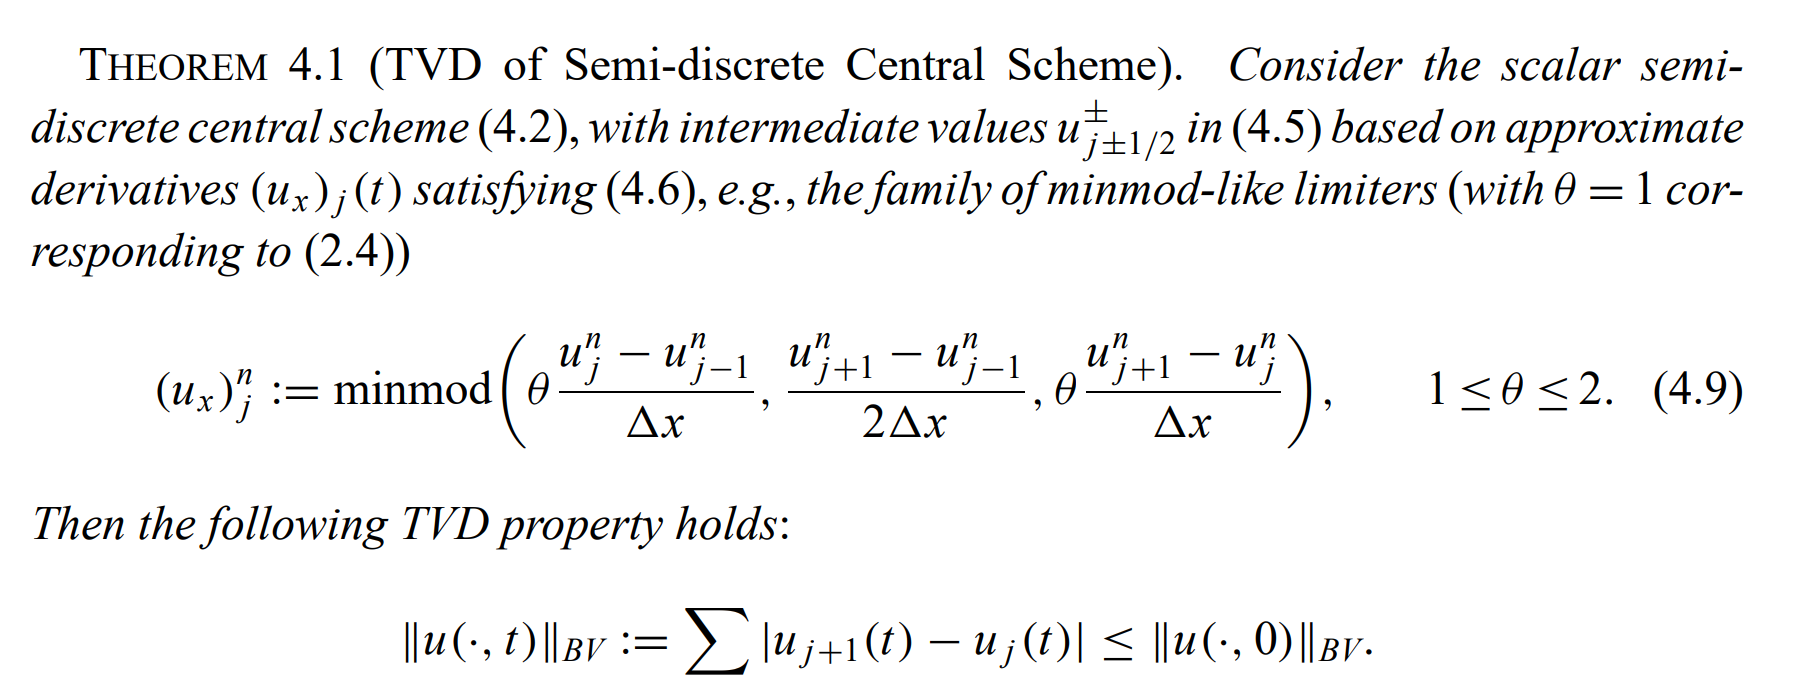

In [7]:

def getGradient(f, dx, theta=1):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter 1 <= theta <= 2

    """
    # directions for np.roll()
    R = -1   # right
    L = 1    # left

    df_dx = minmod3( theta * ( f - np.roll(f,L,axis=0) )/dx, (np.roll(f,R,axis=0) - np.roll(f,L,axis=0) ) / (2*dx),theta * ( np.roll(f,R,axis=0) - f ) / dx)

    return df_dx


def local_propagation_speed(rho, vx, Pi, gamma, B):

   '''
    Get the local propagation speeds using the eigenvalues
    of the flux matrix of the non relativistic IS equations

    rho          is a matrix of left-state  density
    vx           is a matrix of x-velocity
    Pi           is a matrix of bulk viscosity
    cs           is the speed of sound
    '''

   cs = getSpeedOfSound(rho, gamma)

   C = np.abs(vx) + np.emath.sqrt((cs**2 + (Pi+B)/rho)/gamma)

   return C



Modified Runge-Kutta time integrator
Heun's Method

In [8]:
def Euler(q , C , dt):
    '''
    Foward Euler timestep

    q   is the field we are updating
    C   is the dq/dt
    dt  is the timestep


    '''
    E = q + dt * C

    return E


def modified_RungeKutta(q, C, dt, s=2):

    '''
    Modified Runge-Kutta integrator

    q   is the field we are updating
    C   is the dq/dt
    dt  is the timestep
    s   is the optional parameter for the order of the integrator

    This function updates the q field by one timestep using the numerical
    derivative of q over time (Heun's Method if s = 2)
    I did not implement higher order RK yet
    '''

    bl = 0.5

    A = q.shape[0]
    try:
      B = q.shape[1]
      y = np.empty([s,A,B])
    except:
      y = np.empty([s,A])

    y[0:] = Euler(q,C,dt) # foward euler step

    for i in range(s):
        y[i] = bl * q + (1 - bl)*Euler(y[0],C,dt)

    return y[s-1]

def Heuns(q,f,dt,t):

  k1 = dt*f(t,q)
  k2 = dt*f(t + dt,q + k1)

  return q + 1/2 * (k1 + k2)



def RK4(y0,f,h,t):

  k1 = h * (f(t, y0))
  k2 = h * (f((t+h/2), (y0+k1/2)))
  k3 = h * (f((t+h/2), (y0+k2/2)))
  k4 = h * (f((t+h), (y0+k3)))
  k = (k1+2*k2+2*k3+k4)/6
  yn = y0 + k

  return yn



These intermediate values are given by

$ q^{+}_{i + 1/2} \equiv q_{i + 1} - \frac{\Delta x}{2} (q_{x})_{i + 1} $

$ q^{-}_{i + 1/2} \equiv q_{i} + \frac{\Delta x}{2} (q_{x})_{i} $

$ q^{+}_{i - 1/2} \equiv q_{i} - \frac{\Delta x}{2} (q_{x})_{i} $

$ q^{-}_{i - 1/2} \equiv q_{i-1} + \frac{\Delta x}{2} (q_{x})_{i-1} $



In [9]:
def extrapolateInSpaceToFace(q, q_dx, dx):

  """
  Calculate the gradients of a field
  q        is a matrix of the field
  q_dx     is a matrix of the field x-derivatives
  dx       is the cell size
  q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
  q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
  """

  # directions for np.roll()
  R = -1   # right
  L = 1    # left

  qP_XL = q - q_dx * dx/2 # minus
  qP_XR = np.roll(q,R,axis=0) - np.roll(q_dx,R,axis=0) * dx/2
  qM_XR = q + q_dx * dx/2
  qM_XL = np.roll(q,L,axis=0) + np.roll(q_dx,L,axis=0) * dx/2

  return qM_XL, qP_XL, qM_XR, qP_XR

The numerical fluxes are given by

$H_{i \pm 1/2}^{x} \equiv \frac{F^{x}[q^{+}_{i \pm 1/2}] + F^{x}[q^{-}_{i \pm 1/2}]}{2} - a^{x}_{i \pm 1/2} \frac{q^{+}_{i \pm 1/2} - q^{-}_{i \pm 1/2}}{2}$

The KT algorithm makes use of the local
propagation speed at each cell interface, defined as

$a^{x}_{i \pm 1/2} =\max \{ \rho(\frac{\partial F^{x}}{ \partial q}[q^{+}_{i \pm 1/2}]), \rho(\frac{\partial F^{x}}{ \partial q}[q^{-}_{i \pm 1/2}]) \}$

In [10]:
def getFlux(rho_P, rho_M, vx_P, vx_M, Pi_P, Pi_M, P_P, P_M, gamma, B):

  """

  Calculate fluxes between 2 states with local Kurganov Tadmor rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density
  vx_P         is a matrix of left-state  x-velocity
  vx_M         is a matrix of right-state x-velocity
  Pi_P         is a matrix of left-state bulk viscosity
  Pi_M         is a matrix of right-state bulk viscosity
  P_P          is a matrix of left-state  pressure
  P_M          is a matrix of right-state pressure
  gamma        is the ideal gas gamma
  flux_Mass    is the matrix of mass fluxes
  flux_Momx    is the matrix of x-momentum fluxes
  flux_Pi_v    is the matrix of the bulk viscosity var

  """


  # compute (averaged) states over the left and right states
  rho_av   = 0.5*(rho_P + rho_M)
  momx_av  = 0.5*(rho_P * vx_P + rho_M * vx_M)
  Pi_av    = 0.5*(Pi_P + Pi_M)
  Pi_vx_av = 0.5*(Pi_P * vx_P + Pi_M * vx_M)
  P_av     = 0.5*(P_P + P_M)

  # compute fluxes (local Kurganov-Tadmor)

  flux_Mass   = momx_av
  flux_Momx   = 0.5*(rho_P*(vx_P)**2 + rho_M*(vx_M)**2) + ( P_av + Pi_av)/gamma
  flux_Pi_v   = Pi_vx_av + B * (vx_P + vx_M)*0.5

  # find wavespeeds

  C_P = local_propagation_speed(rho_P , vx_P, Pi_P, gamma, B) # max propagation speed from the left

  C_M = local_propagation_speed(rho_M , vx_M, Pi_M, gamma, B) # max propagation speed from the right

  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass   -= C * 0.5 * (rho_P - rho_M)
  flux_Momx   -= C * 0.5 * (rho_P * vx_P - rho_M * vx_M)
  flux_Pi_v   -= C * 0.5 * ( Pi_P - Pi_M )

  return flux_Mass, flux_Momx, flux_Pi_v

$ \frac{d}{d\tau} q_{i} = -\frac{H_{i+1/2}^{x} -H_{i-1/2,j,k}^{x}}{\Delta x}+ J[q_{i}] $

In [11]:
def applyFluxes(flux_H1_X, flux_H2_X , dx, J = 0):
    """
    Apply fluxes to conserved variables
    H         is a matrix of the conserved variable field
    flux_H1_X is a matrix of the x-dir fluxes from the right
    flux_H2_X is a matrix of the x-dir fluxes from the left
    dx        is the cell size
    """
    C = 0

    # update solution
    C -= (flux_H1_X - flux_H2_X ) / dx
    C += J

    return C

non relativistic IS
time 1.0001618127860674


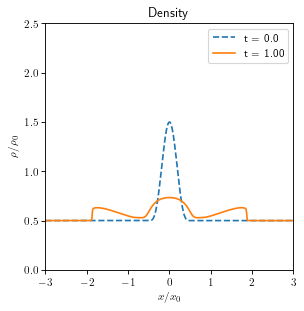

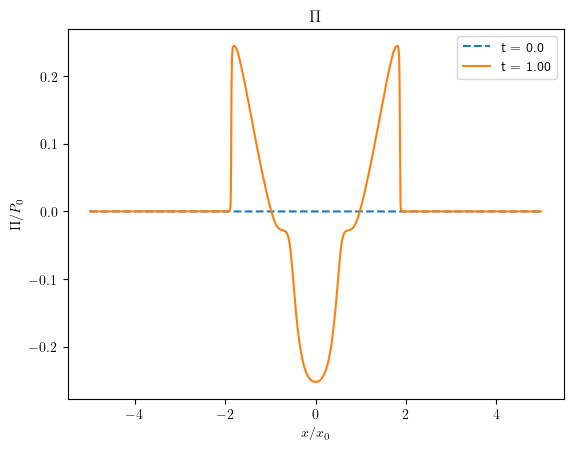

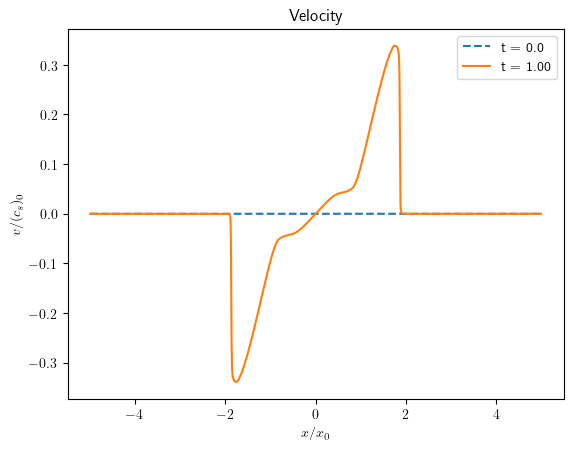

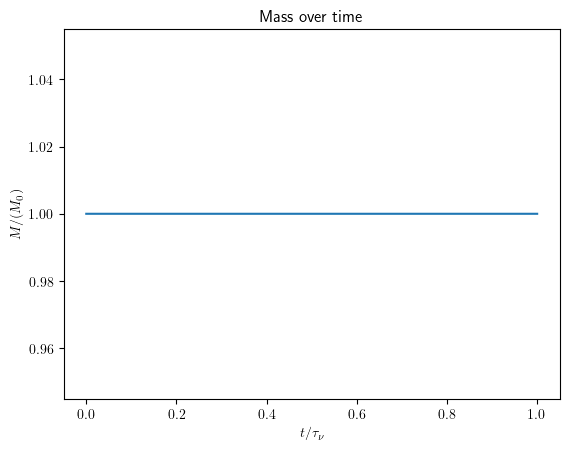

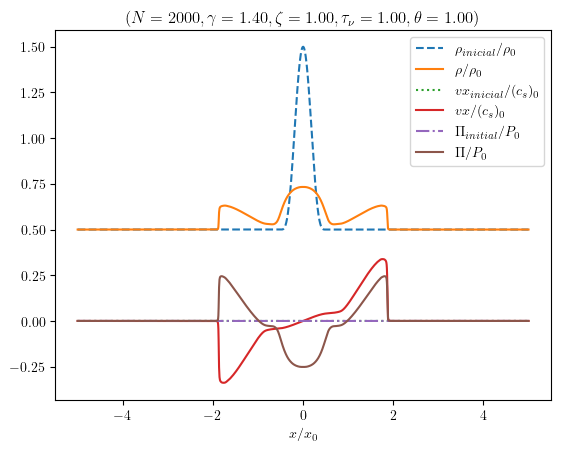

This is the evolved solution


<Figure size 640x480 with 0 Axes>

In [71]:
def main():
    """ Finite Volume simulation """

    # Simulation parameters
    N                      = 2000 # resolution
    boxsize                = 10.  # in some unit system l
    gamma                  = 1.4 # adiabatic index
    zeta                   = 1 # bulk viscosity coefficient
    tau_nu                 = 1
    t                      = 0   # initial time
    tEnd                   = 1   # time at the end
    tOut                   = 0.01 # time of each output
    theta                  = 1
    plotRealTime = False # switch on for plotting as the simulation goes along
    plotInOne = True



    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Define Mesh
    dx = boxsize / N   # box size
    vol = dx**2        # volume of each box
    a = -0.5*(boxsize-0.5*dx)
    b = 0.5*(boxsize-0.5*dx)
    xlin = np.linspace(a, b, N)# simulation limits


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Generate Initial Conditions

    ''' Initial conditions for rho '''
    rho = ((1 - ((xlin)**2)/0.25 )**4 )*(np.abs(xlin)<0.5) + 0.5*np.ones(xlin.shape) # Mauricio`s funtion advice
    #rho = 1*(xlin < 0) + 0.125*(xlin >= 0)



    ''' Initial conditions for v'''
    vx = np.zeros(xlin.shape)
    #vx = np.sin(xlin)
    #vx = 0.5*np.ones(xlin.shape)
    #vx = np.abs((xlin - (boxsize-0.5*dx)*0.5)/16)

    ''' Pressure due to equation of state '''
    P = (rho)**gamma

    ''' B Constant '''
    B = zeta/tau_nu

    ''' Pi initial condition '''
    Pi = np.zeros(xlin.shape)


    rhoic = rho
    vxic = vx
    Piic = Pi

    # getSpeedOfSound(rho, gamma)
    cs = getSpeedOfSound(rho,gamma)



    #-----------------------------------------------------------------------------------------------------------------------------------#

    # average mass
    M0 = np.sum(rho*vol)
    M  = M0.copy() / M0
    # array that stores the times at which the values are calculated
    times = np.array([t])

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # prep figure
    fig = plt.figure(figsize=(4,4), dpi=80)
    outputCount = 1

    #-----------------------------------------------------------------------------------------------------------------------------------#


    # Simulation Main Loop
    while t < tEnd:

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # get Conserved variables
        Mass, Momx, Pi_vx = getConserved( rho, vx, Pi, vol)

        M = np.vstack((M, np.sum(Mass/M0)))


        if np.any(Mass < 0):
          print("Mass is negative", t)

        # get Primitive variables
        rho, vx, P = getPrimitive( Mass, Momx, gamma, vol )

        #-----------------------------------------------------------------------------------------------------------------------------------#

        cs = getSpeedOfSound(rho, gamma)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # get time step

        dt = np.minimum(0.01, 0.1*np.min(dx/local_propagation_speed(rho, vx, Pi, gamma, B)))

        #print(dt)

        times = np.hstack((times, t + dt))

        plotThisTurn = False

        if t + dt > outputCount*tOut:
            plotThisTurn = True

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # calculate gradients
        # getGradient(f, dx, theta=1)

        rho_dx = getGradient(rho,  dx,theta)
        vx_dx  = getGradient(vx,   dx,theta)
        P_dx   = getGradient(P,    dx,theta)
        Pi_dx  = getGradient(Pi,   dx,theta)


        #-----------------------------------------------------------------------------------------------------------------------------------#

        # extrapolate in space to face centers
        # input extrapolateInSpaceToFace(q, q_dx, dx)
        # output qM_XL, qP_XL, qM_XR, qP_XR

        rhoM_XL, rhoP_XL, rhoM_XR, rhoP_XR = extrapolateInSpaceToFace(rho, rho_dx, dx)
        vxM_XL,  vxP_XL,  vxM_XR,  vxP_XR  = extrapolateInSpaceToFace(vx,  vx_dx,  dx)
        PM_XL,   PP_XL,   PM_XR,   PP_XR   = extrapolateInSpaceToFace(P,   P_dx,   dx)
        PiM_XL,  PiP_XL,  PiM_XR,  PiP_XR  = extrapolateInSpaceToFace(Pi,  Pi_dx,  dx)

        #if testTVD:
        # if np.any(rho_dx/ (rhoP_XR - rhoP_XL)) > 2 or  np.any(rho_dx/ (rhoM_XR - rhoM_XL)) > 2:
        #   print("rho is not TVD")


        #-----------------------------------------------------------------------------------------------------------------------------------#

        # compute fluxes (local Kurganov-Tadmor)
        # getFlux(rho_P, rho_M, vx_P, vx_M, Pi_P, Pi_M, P_P, P_M, gamma, B)
        # output flux_Mass, flux_Momx, flux_Pi_v

        flux_Mass_XR, flux_Momx_XR, flux_Pi_vxR = getFlux(rhoP_XR, rhoM_XR, vxP_XR, vxM_XR, PiP_XR, PiM_XR, PP_XR, PM_XR, gamma, B)
        flux_Mass_XL, flux_Momx_XL, flux_Pi_vxL = getFlux(rhoP_XL, rhoM_XL, vxP_XL, vxM_XL, PiP_XL, PiM_XL, PP_XL, PM_XL, gamma, B)




        #-----------------------------------------------------------------------------------------------------------------------------------#

        # update solution

        J = - Pi/tau_nu


        rho    = modified_RungeKutta(rho,   applyFluxes( flux_Mass_XR,   flux_Mass_XL,   dx),    dt)
        vx     = np.divide(modified_RungeKutta(Momx,  applyFluxes( flux_Momx_XR,   flux_Momx_XL,   dx),    dt), rho,
                         out=np.zeros_like(modified_RungeKutta(Momx,  applyFluxes( flux_Momx_XR,   flux_Momx_XL,   dx), dt)), where=rho!=0)
        Pi     = modified_RungeKutta(Pi, applyFluxes( flux_Pi_vxR,    flux_Pi_vxL,    dx, J), dt)



        #-----------------------------------------------------------------------------------------------------------------------------------#

        # Boundary conditions



        rho[0]    = rho[1]
        rho[-1]   = rho[-2]


        vx[0]     = vx[1]
        vx[-1]    = vx[-2]

        Pi[0]     = 0
        Pi[-1]    = 0






        #-----------------------------------------------------------------------------------------------------------------------------------#

        # update time
        t += dt

        #-----------------------------------------------------------------------------------------------------------------------------------#


        # plot in real time
        if (plotRealTime and plotThisTurn) or (t >= tEnd):
            plt.cla()
            plt.plot(xlin,rhoic,label='t = 0.0', linestyle='dashed')
            plt.plot(xlin,rho,label='t = {:.2f}'.format(t))
            plt.title('Density')
            plt.xlim((-3,3))
            plt.ylim(0,2+0.5)
            plt.xlabel(r'$x/x_0$')
            plt.ylabel(r'$\rho/\rho_{0}$')
            print("time",t)
            plt.legend()
            plt.show()
            plt.plot(xlin,Piic,label='t = 0.0', linestyle = 'dashed')
            plt.plot(xlin,Pi,label='t = {:.2f}'.format(t))
            plt.title(r'$\Pi$')
            plt.xlabel(r'$x/x_0$')
            plt.ylabel(r'$\Pi/P_0$')
            plt.legend()
            plt.show()
            plt.plot(xlin,vxic, label='t = 0.0', linestyle='dashed')
            plt.plot(xlin,vx, label='t = {:.2f}'.format(t))
            plt.title('Velocity')
            plt.xlabel(r'$x/x_0$')
            plt.ylabel(r'$v/(c_s)_0$')
            plt.legend()
            plt.show()
            plt.plot(times, M)
            plt.title('Mass over time')
            plt.xlabel(r'$t/\tau_{\nu}$')
            plt.ylabel(r'$M/(M_0)$')
            plt.show()
            plt.pause(0.001)
            outputCount += 1

        if (plotRealTime and plotThisTurn and plotInOne) or (t >= tEnd):
            plt.plot(xlin,rhoic,label=r'$\rho_{inicial}/\rho_0$', linestyle='dashed')
            plt.plot(xlin,rho,label=r'$\rho/\rho_0$')
            plt.plot(xlin,vxic, label=r'$vx_{inicial}/(c_s)_0$', linestyle='dotted')
            plt.plot(xlin,vx, label=r'$vx/(c_s)_0$')
            plt.plot(xlin,Piic,label=r'$\Pi_{initial}/P_0$', linestyle = 'dashdot')
            plt.plot(xlin,Pi,label=r'$\Pi/P_0$')
            plt.title(r'$(N = {},\gamma = {:.2f}, \zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
            plt.xlabel('$x/x_0$')
            plt.legend()
            plt.show()
       #-----------------------------------------------------------------------------------------------------------------------------------#






    # Save figure
    plt.savefig('finitevolume.png',dpi=240)

    print("This is the evolved solution")
    plt.show()


    return 0



if __name__== "__main__":
  print("non relativistic IS")
  main()


# function for creating a solution array



In [48]:
def KTschemeNonRelativisticIS(t,IC, dx, xlin, gamma, zeta, tau_nu, BC = None, theta=1):

    """ Finite Volume simulation """

    if BC is not None:
      BC(IC)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Generate Initial Conditions

    ''' Initial conditions for rho '''
    rho = IC[0:N]

    ''' Initial conditions for v'''
    vx = IC[N:2*N] / rho
    ''' Pressure due to equation of state '''
    P = (rho)**gamma

    ''' B Constant '''
    B = zeta/tau_nu

    ''' Pi initial condition '''
    Pi = IC[2*N:]


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # get Conserved variables
    vol = dx*dx
    Mass, Momx, Pi_vx = getConserved( rho, vx, Pi, vol)


    # get Primitive variables
    rho, vx, P = getPrimitive( Mass, Momx, gamma, vol )


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # calculate gradients
    # getGradient(f, dx, theta=1)

    rho_dx = getGradient(rho,  dx,theta)
    vx_dx  = getGradient(vx,   dx,theta)
    P_dx   = getGradient(P,    dx,theta)
    Pi_dx  = getGradient(Pi,   dx,theta)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # extrapolate in space to face centers
    # input extrapolateInSpaceToFace(q, q_dx, dx)
    # output qM_XL, qP_XL, qM_XR, qP_XR

    rhoM_XL, rhoP_XL, rhoM_XR, rhoP_XR = extrapolateInSpaceToFace(rho, rho_dx, dx)
    vxM_XL,  vxP_XL,  vxM_XR,  vxP_XR  = extrapolateInSpaceToFace(vx,  vx_dx,  dx)
    PM_XL,   PP_XL,   PM_XR,   PP_XR   = extrapolateInSpaceToFace(P,   P_dx,   dx)
    PiM_XL,  PiP_XL,  PiM_XR,  PiP_XR  = extrapolateInSpaceToFace(Pi,  Pi_dx,  dx)


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # compute fluxes (local Kurganov-Tadmor)
    # input getFlux(rho_P, rho_M, vx_P, vx_M, Pi_P, Pi_M, P_P, P_M, gamma, B)
    # output flux_Mass, flux_Momx, flux_Pi_v

    flux_Mass_XR, flux_Momx_XR, flux_Pi_vxR = getFlux(rhoP_XR, rhoM_XR, vxP_XR, vxM_XR, PiP_XR, PiM_XR, PP_XR, PM_XR, gamma, B)
    flux_Mass_XL, flux_Momx_XL, flux_Pi_vxL = getFlux(rhoP_XL, rhoM_XL, vxP_XL, vxM_XL, PiP_XL, PiM_XL, PP_XL, PM_XL, gamma, B)


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # get time derivative

    J = - Pi/tau_nu
    timederivative_rho = applyFluxes( flux_Mass_XR,   flux_Mass_XL,   dx)
    timederivative_Momx = applyFluxes( flux_Momx_XR,   flux_Momx_XL,   dx)
    timederivative_Pi  = applyFluxes( flux_Pi_vxR,    flux_Pi_vxL,    dx, J)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    return np.hstack((timederivative_rho,timederivative_Momx,timederivative_Pi))

def integrator(scheme, time, y0, dtmax, BC, method = "Heuns", args=None):

  '''
  This is an integrator that evolves a

  scheme     is the method to get dy/dt e.g. KTscheme
  time       is the current time
  y0         is the current state
  dtmax      is the upperbound of dt set by the user
  BC         is a function that enforces the boundary conditions
  method     is the method used in the integrator
  args       are additional arguments for scheme
  '''

  if args is not None:
        # Wrap the user's scheme in lambdas to hide the
        # additional parameters.  Pass in the original fun as a keyword
        # argument to keep it in the scope of the lambda.
        try:
            _ = [*(args)]
        except TypeError as exp:
            suggestion_tuple = (
                "Supplied 'args' cannot be unpacked. Please supply `args`"
                f" as a tuple (e.g. `args=({args},)`)")
            raise TypeError(suggestion_tuple) from exp

        scheme = lambda t, x, scheme = scheme: scheme(t, x, *args)

  t, tEnd = time

  Y = [y0]
  y = y0
  times = [0]
  N = int(args[1].shape[0])
  M = []
  outputCount = 1
  while t < tEnd:

    C = scheme
    if args is not None:
      mlps = np.max(local_propagation_speed(y[0:N],y[N:2*N]/y[0:N],y[2*N:], args[2], args[3]/args[4]))
      if mlps != 0:
        dtlocal = 0.5*args[0] / mlps
      else:
        dtlocal = 0

    if dtlocal > 0:
      dt  = np.minimum(dtmax,dtlocal)
    else:
      dt = dtmax


    if method == "Heuns":
      y = Heuns(y,C,dt,t)
    if method == "RK4":
      y = RK4(y,C,dt,t)

    #Apply Boundary conditions

    BC(y)

    t = t + dt
    if t >= dtmax*outputCount:
      Y.append(y)
      M.append(np.sum(rho*args[0]*args[0]))
      times.append(t)
      print(t)
      outputCount += 1


  return Y, M, times

def applyBC(y):

  rho = y[0:N]
  vx = y[N:2*N]/rho
  Pi = y[2*N:]

  '''Absorbing boundary conditions'''

  rho[0]    = rho[1]
  rho[-1]   = rho[-2]


  vx[0]     = vx[1]
  vx[-1]    = vx[-2]

  Pi[0]     = 0
  Pi[-1]    = 0

  y[0:N] = rho
  y[N:2*N] = rho*vx
  y[2*N:] = Pi




t                      = 0   # s
tEnd                   = 2   # time at the end
tOut                   = 0.01 # time of each output

N                      = 1000 # resolution
boxsize                = 10.  # in some unit system l
gamma                  = 5/3  # adiabatic index
zeta                   = 0.01 # bulk viscosity coefficient
tau_nu                 = 1
theta                  = 1


# Define Mesh
dx = boxsize / N   # box size
vol = dx**2        # volume of each box
a = -0.5*(boxsize-0.5*dx)
b = 0.5*(boxsize-0.5*dx)
xlin = np.linspace(a, b, N)# simulation limits



#rho = ((1 - ((xlin - (boxsize-0.5*dx)*0.5)**2)/0.25 )**4 ) + 0.5*np.ones(xlin.shape) # Mauricio`s funtion advice
rho = ((1 - ((xlin)**2)/0.25 )**4 )*(np.abs(xlin)<0.5) + 0.5*np.ones(xlin.shape) # Mauricio`s funtion advice
#rho = 1*(xlin < 0) + 0.4*(xlin >= 0)
#rho = (2*(np.abs(xlin) <= 1*0.25) + 1*(np.abs(xlin) > 1*0.25))

vx = np.zeros(xlin.shape)
#vx = 0.5*np.ones(xlin.shape)
#vx = np.abs((xlin - (boxsize-0.5*dx)*0.5)/16)


Pi = np.zeros(xlin.shape)

IC = np.hstack((rho,rho*vx,Pi)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example



solution, mass , t = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, 0.01, applyBC, args=(dx, xlin, gamma, zeta, tau_nu, None, theta))

np.save("KT1plus1BulkNonRelativisticIS",np.array(solution))
np.save("massOvertime",np.array(mass))

0.014019716988063376
0.022298592537767746
0.030220342759600984
0.04193550673317393
0.05364004661314971
0.06147934901075099
0.07328445568430929
0.08114893299466223
0.0929401693500365
0.10080872246679363
0.11262513982576468
0.12050261241496975
0.13231384145763206
0.14019144258235122
0.15201037396749664
0.16382918346212458
0.1717089614232467
0.18353058505608802
0.19141121000048297
0.2032319417279268
0.21111232215200848
0.22293309700708008
0.23081374756121184
0.24263471224033376
0.2505148271503823
0.26233453657133454
0.2702140915034366
0.28203322070943637
0.2938521423410244
0.30173128935783183
0.31354950548438665
0.3214280382715997
0.33324563528106965
0.3411239581478206
0.3529413611130937
0.3608195252405278
0.3726364962211412
0.38051431310257855
0.39233087363026703
0.40020851299284166
0.4120248154666118
0.42384086682997657
0.43171808629754105
0.44353370200031744
0.4514106801388509
0.4632260138883113
0.4711028204496733
0.4829178920410531
0.49079450535729546
0.5026093306653328
0.510485815559

In [ ]:
solution = np.load("KT1plus1BulkNonRelativisticIS.npy",allow_pickle=False)

In [ ]:
print(len(solution))

201


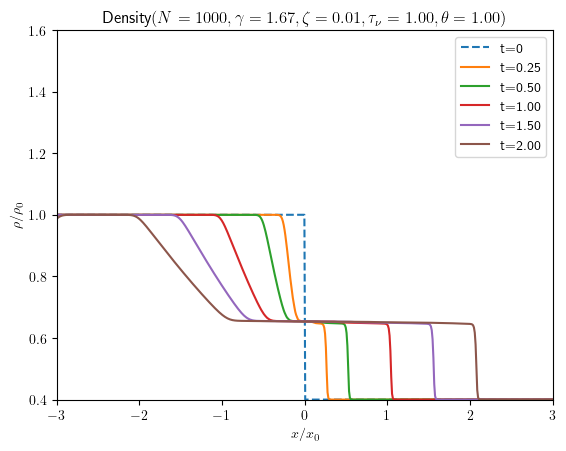

In [49]:
plt.plot(xlin,solution[0][0:N], label='t=0', linestyle='dashed')
plt.plot(xlin,solution[25][0:N],label='t={:.2f}'.format(tEnd/8))
plt.plot(xlin,solution[50][0:N],label='t={:.2f}'.format(tEnd/4))
plt.plot(xlin,solution[100][0:N],label='t={:.2f}'.format(tEnd/2))
plt.plot(xlin,solution[150][0:N],label='t={:.2f}'.format(3*tEnd/4))
plt.plot(xlin,solution[-1][0:N],label='t={:.2f}'.format(tEnd))
plt.title(r'Density$(N = {},\gamma = {:.2f}, \zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
plt.xlim((-3,3))
plt.ylim(0.4,1+0.6)
plt.xlabel(r'$x/x_0$')
plt.ylabel(r'$\rho/\rho_{0}$')
plt.legend()
plt.show()

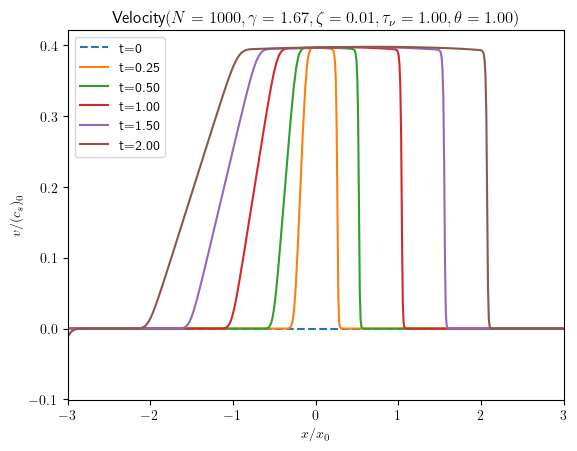

In [50]:
plt.plot(xlin,solution[0][N:2*N]/solution[0][0:N], label='t=0', linestyle='dashed')
plt.plot(xlin,solution[25][N:2*N]/solution[25][0:N],label='t={:.2f}'.format(tEnd/8))
plt.plot(xlin,solution[50][N:2*N]/solution[50][0:N],label='t={:.2f}'.format(tEnd/4))
plt.plot(xlin,solution[100][N:2*N]/solution[100][0:N],label='t={:.2f}'.format(tEnd/2))
plt.plot(xlin,solution[150][N:2*N]/solution[150][0:N],label='t={:.2f}'.format(3*tEnd/4))
plt.plot(xlin,solution[-1][N:2*N]/solution[-1][0:N],label='t={:.2f}'.format(tEnd))
plt.title(r'Velocity$(N = {}, \gamma = {:.2f},\zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
plt.xlim((-3,3))
plt.xlabel('$x/x_0$')
plt.ylabel('$ v / (c_s)_{0}$')
plt.legend()
plt.show()

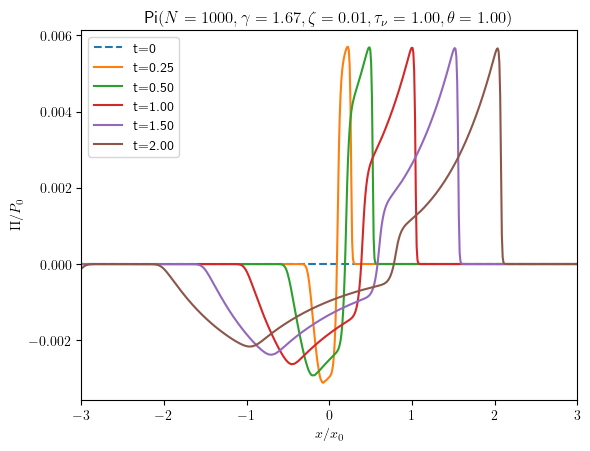

In [51]:
plt.plot(xlin,solution[0][2*N:], label='t=0', linestyle='dashed')
plt.plot(xlin,solution[25][2*N:],label='t={:.2f}'.format(tEnd/8))
plt.plot(xlin,solution[50][2*N:],label='t={:.2f}'.format(tEnd/4))
plt.plot(xlin,solution[100][2*N:],label='t={:.2f}'.format(tEnd/2))
plt.plot(xlin,solution[150][2*N:],label='t={:.2f}'.format(3*tEnd/4))
plt.plot(xlin,solution[-1][2*N:],label='t={:.2f}'.format(tEnd))

plt.title(r'Pi$(N = {}, \gamma = {:.2f},\zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
plt.xlim((-3,3))
plt.xlabel('$x/x_0$')
plt.ylabel('$\Pi/P_{0}$')
plt.legend()
plt.show()

Text(0, 0.5, '$M/M_0$')

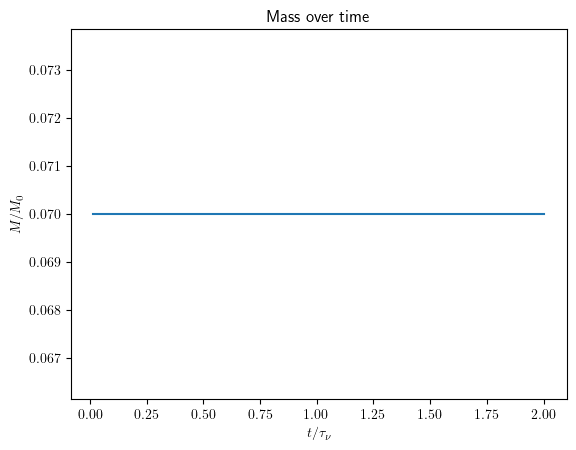

In [55]:
plt.plot(t[1:], mass)
plt.title(r'Mass over time')
plt.xlabel(r'$t/\tau_{\nu}$')
plt.ylabel(r'$M/M_0$')

In [ ]:
def init():
    line.set_data([], [])
    return (line,)
'''
def update(dt):
  for i in range(len(x)):
    lab = 'Time:'+str(dt+dt*i)
    L.get_texts()[0].set_text(lab)
  return leg
'''

def animate_density(i):
  x = xlin
  y = solution[i][0:N]
  line.set_data(x, y)
  time.set_text(i)
  return (line,)

def animate1_density(i):
  x = xlin
  y = solution1[i][0:N]
  line.set_data(x, y)
  time.set_text(i)
  return (line,)



parameters: gamma = 1.6666666666666667, theta = 1, resolution = 1000


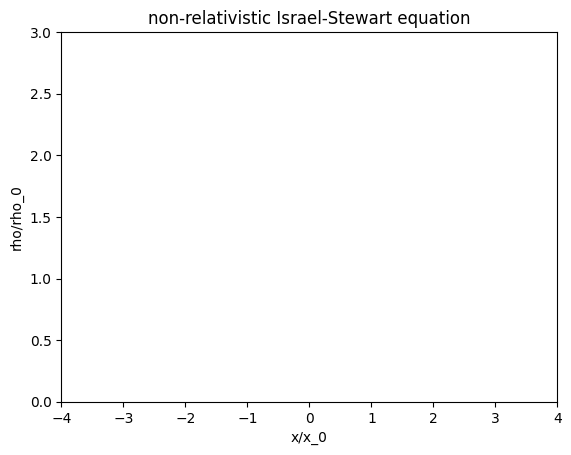

In [ ]:
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

figure = plt.figure()
ax1 = plt.subplot(1,1,1)




# set ax boundaries
ax1.set_xlim((-4,4))
ax1.set_ylim((0, 3))
line, = ax1.plot([], [], lw=2)
time = ax1.annotate(0, xy=(1, 8), xytext=(1, 8))
ax1.set_xlabel('x/x_0')
ax1.set_ylabel('rho/rho_0')
ax1.set_title('non-relativistic Israel-Stewart equation')

ani = animation.FuncAnimation(figure, animate_density, init_func=init,
                               frames=200, interval=20, blit=True)

#ani1 = animation.FuncAnimation(figure, animate1_density, init_func=init,
#                               frames=1000, interval=10, blit=True)

print("parameters: gamma = {}, theta = {}, resolution = {}".format(gamma,theta,N))

In [ ]:
HTML(ani.to_html5_video())

In [ ]:
HTML(ani1.to_html5_video())

# 2D code



In [72]:
import numpy as np
import matplotlib.pyplot as plt


def getConserved( rho, vx, vy, vol ):
    """
    Calculate the conserved variable from the primitive
    rho      is matrix of cell densities
    vx       is matrix of cell x-velocity
    vy       is matrix of cell y-velocity
    gamma    is ideal gas gamma
    vol      is cell volume
    Mass     is matrix of mass in cells
    Momx     is matrix of x-momentum in cells
    Momy     is matrix of y-momentum in cells
    """
    Mass   = rho * vol
    Momx   = rho * vx
    Momy   = rho * vy

    return Mass, Momx, Momy

def getPrimitive( Mass, Momx, Momy, gamma, vol):
  """
  Calculate the primitive variable from the conservative
  Mass     is matrix of mass in cells
  Momx     is matrix of x-momentum in cells
  Momy     is matrix of y-momentum in cells
  gamma    is ideal gas gamma
  vol      is cell volume
  rho      is matrix of cell densities
  vx       is matrix of cell x-velocity
  vy       is matrix of cell y-velocity
  P        is matrix of cell pressures
  """
  rho = Mass / vol
  vx  = Momx / rho
  vy  = Momy / rho
  P   = (rho)**gamma

  return rho, vx, vy, P

def getSpeedOfSound(rho, gamma):

  '''
  find the speed of sound in the fluid
  rho
  '''

  cs = np.sqrt((gamma)*rho**(gamma-1))

  return cs


'''
These are auxiliary functions in for the gradient
'''

def minmod2(x,y):
  return (np.sign(x) + np.sign(y))*np.minimum(np.abs(x), np.abs(y))/2

def minmod3(x,y,z):
  return minmod2(x,minmod2(y,z))


def getGradient(f, dx, axis=0, theta=1):

    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size in x direction
    axis     is the axis of x-direction
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter 1 <= theta <= 2

    """


    df_dx = np.zeros(f.shape)
    n = f.shape[axis]
    K = np.arange(0, n)
    Kp1 = np.roll(K, -1)
    Km1 = np.roll(K, 1)

    if axis == 0:
      df_dx =  minmod3( theta * ( f - f[Km1][:, K] )/dx, (f[Kp1][:, K] - f[Km1][:, K] ) / (2*dx),theta * ( f[Kp1][:, K] - f ) / dx)
    elif axis == 1:
      df_dx = minmod3( theta * ( f - f[K][:, Km1] )/dx, (f[K][:, Kp1] - f[K][:, Km1] ) / (2*dx),theta * ( f[K][:, Kp1] - f ) / dx)

    return df_dx


def extrapolateInSpaceToFace(q, q_dx, dx, axis=0):

    """

    Calculate the gradients of a field
    q        is a matrix of the field
    q_dx     is a matrix of the field x-derivatives
    dx       is the cell size
    q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
    q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis

    """

    n,_ = q.shape

    K = np.arange(0, n)
    Kp1 = np.roll(K, -1)
    Km1 = np.roll(K, 1)


    qP_XL = np.zeros_like(q)
    qP_XR = np.zeros_like(q)
    qM_XR = np.zeros_like(q)
    qM_XL = np.zeros_like(q)

    if axis == 0:

      qP_XL = q - q_dx * dx/2
      qP_XR = q[Kp1][:, K] - q_dx[Kp1][:, K] * dx/2
      qM_XR = q + q_dx * dx/2
      qM_XL = q[Km1][:, K] + q_dx[Km1][:, K] * dx/2

    elif axis == 1:

      qP_XL = q - q_dx * dx/2
      qP_XR = q[K][:, Kp1] - q_dx[K][:, Kp1] * dx/2
      qM_XR = q + q_dx * dx/2
      qM_XL = q[K][:, Km1] + q_dx[K][:, Km1] * dx/2

    return qM_XL, qP_XL, qM_XR, qP_XR


def local_propagation_speed(rho, vx, Pi, gamma, B):

    '''
    Get the local propagation speeds using the eigenvalues
    of the flux matrix of the non relativistic IS equations

    rho          is a matrix of density
    Pi           is the matrix of bulk viscosity
    B
    gamma
    cs           is the speed of sound

    '''


    cs = getSpeedOfSound(rho, gamma)

    C = np.abs(vx) + np.sqrt(cs**2/gamma + (Pi+B)/(rho*gamma))

    return C

def getXFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, Pi_P, Pi_M, P_P, P_M, gamma, B):

  """

  Calculate fluxes between 2 states with local Kurganov Tadmor rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density
  vx_P         is a matrix of left-state  x-velocity
  vx_M         is a matrix of right-state x-velocity
  vy_P         is a matrix of left-state  y-velocity
  vy_M         is a matrix of right-state y-velocity
  Pi_P         is a matrix of left-state bulk viscosity
  Pi_M         is a matrix of right-state bulk viscosity
  P_P          is a matrix of left-state  pressure
  P_M          is a matrix of right-state pressure
  gamma        is the ideal gas gamma
  flux_Mass    is the matrix of mass fluxes
  flux_Momx    is the matrix of x-momentum fluxes
  flux_Pi_v    is the matrix of the bulk viscosity var

  """


  # compute (averaged) states over the left and right states
  rho_av   = 0.5*(rho_P + rho_M)
  momx_av  = 0.5*(rho_P * vx_P + rho_M * vx_M)
  Pi_av    = 0.5*(Pi_P + Pi_M)
  Pi_vx_av = 0.5*(Pi_P * vx_P + Pi_M * vx_M)
  P_av     = 0.5*(P_P + P_M)

  # compute fluxes (local Kurganov-Tadmor)

  flux_Mass   = momx_av
  flux_Momx   = 0.5*(rho_P*(vx_P)**2 + rho_M*(vx_M)**2) + (P_av + Pi_av)/gamma
  flux_Momy   = 0.5*(rho_P*(vy_P)*vx_P + rho_M*(vy_M)*vx_M)
  flux_Pi_v   = Pi_vx_av + B * (vx_P + vx_M)*0.5

  # find wavespeeds

  C_P = local_propagation_speed(rho_P , vx_P, Pi_P, gamma, B) # max propagation speed from the left

  C_M = local_propagation_speed(rho_M , vx_M, Pi_M, gamma, B) # max propagation speed from the right

  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass   -= C * 0.5 * (rho_P - rho_M)
  flux_Momx   -= C * 0.5 * (rho_P * vx_P - rho_M * vx_M)
  flux_Momy   -= C * 0.5 * (rho_P * vy_P - rho_M * vy_M)
  flux_Pi_v   -= C * 0.5 * ( Pi_P - Pi_M )

  return flux_Mass, flux_Momx, flux_Momy, flux_Pi_v

def getYFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, Pi_P, Pi_M, P_P, P_M, gamma, B):

  """

  Calculate fluxes between 2 states with local Kurganov Tadmor rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density
  vx_P         is a matrix of left-state  x-velocity
  vx_M         is a matrix of right-state x-velocity
  vy_P         is a matrix of left-state  y-velocity
  vy_M         is a matrix of right-state y-velocity
  Pi_P         is a matrix of left-state bulk viscosity
  Pi_M         is a matrix of right-state bulk viscosity
  P_P          is a matrix of left-state  pressure
  P_M          is a matrix of right-state pressure
  gamma        is the ideal gas gamma
  flux_Mass    is the matrix of mass fluxes
  flux_Momx    is the matrix of x-momentum fluxes
  flux_Pi_v    is the matrix of the bulk viscosity var

  """


  # compute (averaged) states over the left and right states
  rho_av   = 0.5*(rho_P + rho_M)
  momy_av  = 0.5*(rho_P * vy_P + rho_M * vy_M)
  Pi_av    = 0.5*(Pi_P + Pi_M)
  Pi_vy_av = 0.5*(Pi_P * vy_P + Pi_M * vy_M)
  P_av     = 0.5*(P_P + P_M)

  # compute fluxes (local Kurganov-Tadmor)

  flux_Mass   = momy_av
  flux_Momx   = 0.5*(rho_P*(vx_P)*(vy_P) + rho_M*(vx_M)*(vy_M))
  flux_Momy   = 0.5*(rho_P*(vy_P)**2 + rho_M*(vy_M)**2) + (P_av + Pi_av)/gamma
  flux_Pi_v   = Pi_vy_av + B * (vy_P + vy_M)*0.5

  # find wavespeeds

  C_P = local_propagation_speed(rho_P , vy_P, Pi_P, gamma, B) # max propagation speed from the left

  C_M = local_propagation_speed(rho_M , vy_M, Pi_M, gamma, B) # max propagation speed from the right

  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass   -= C * 0.5 * (rho_P - rho_M)
  flux_Momx   -= C * 0.5 * (rho_P * vx_P - rho_M * vx_M)
  flux_Momy   -= C * 0.5 * (rho_P * vy_P - rho_M * vy_M)
  flux_Pi_v   -= C * 0.5 * ( Pi_P - Pi_M )

  return flux_Mass, flux_Momx, flux_Momy, flux_Pi_v

def applyFluxes(flux_H1_X, flux_H2_X, flux_H1_Y, flux_H2_Y, dx, dy, J = 0):
    """
    Apply fluxes to conserved variables
    H         is a matrix of the conserved variable field
    flux_H1_X is a matrix of the x-dir fluxes from the right
    flux_H2_X is a matrix of the x-dir fluxes from the left
    flux_H1_Y is a matrix of the y-dir fluxes from the right
    flux_H2_Y is a matrix of the y-dir fluxes from the left
    dx        is the cell size in the x direction
    dy        is the cell size in the y direction
    """
    C = 0

    # update solution
    C -= (flux_H1_X - flux_H2_X ) / dx
    C -= (flux_H1_Y - flux_H2_Y ) / dy
    C += J

    return C


In [73]:
def KTschemeNonRelativisticIS(t, IC, dx, dy, N, gamma, zeta, tau_nu, theta=1):

    """ Finite Volume simulation """



    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Generate Initial Conditions

    ''' Initial conditions for rho '''
    rho = IC[0:N]

    ''' Initial conditions for v'''
    vx = IC[N:2*N]/rho

    vy = IC[2*N:3*N]/rho

    ''' Pressure due to equation of state '''
    P = (rho)**gamma

    ''' B Constant '''
    B = zeta/tau_nu

    ''' Pi initial condition '''
    Pi = IC[3*N:]


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # get Conserved variables
    vol = dx*dx
    Mass, Momx, Momy = getConserved( rho, vx, vy, vol)


    # get Primitive variables
    rho, vx, vy, P = getPrimitive( Mass, Momx, Momy, gamma, vol )


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # calculate gradients
    # getGradient(f, dx, theta=1)

    rho_dx = getGradient(rho, dx, 0, theta)
    vx_dx  = getGradient(vx,  dx, 0, theta)
    vy_dx  = getGradient(vy,  dx, 0, theta)
    P_dx   = getGradient(P,   dx, 0, theta)
    Pi_dx  = getGradient(Pi,  dx, 0, theta)

    rho_dy = getGradient(rho, dy, 1, theta)
    vx_dy  = getGradient(vx,  dy, 1, theta)
    vy_dy  = getGradient(vy,  dy, 1, theta)
    P_dy   = getGradient(P,   dy, 1, theta)
    Pi_dy  = getGradient(Pi,  dy, 1, theta)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # extrapolate in space to face centers
    # input extrapolateInSpaceToFace(q, q_dx, dx)
    # output qM_XL, qP_XL, qM_XR, qP_XR

    rhoM_XL, rhoP_XL, rhoM_XR, rhoP_XR = extrapolateInSpaceToFace(rho, rho_dx, dx, 0)
    vxM_XL,  vxP_XL,  vxM_XR,  vxP_XR  = extrapolateInSpaceToFace(vx,  vx_dx,  dx, 0)
    vyM_XL,  vyP_XL,  vyM_XR,  vyP_XR  = extrapolateInSpaceToFace(vy,  vy_dx,  dx, 0)
    PM_XL,   PP_XL,   PM_XR,   PP_XR   = extrapolateInSpaceToFace(P,   P_dx,   dx, 0)
    PiM_XL,  PiP_XL,  PiM_XR,  PiP_XR  = extrapolateInSpaceToFace(Pi,  Pi_dx,  dx, 0)


    rhoM_YL, rhoP_YL, rhoM_YR, rhoP_YR = extrapolateInSpaceToFace(rho, rho_dy, dy, 1)
    vxM_YL,  vxP_YL,  vxM_YR,  vxP_YR  = extrapolateInSpaceToFace(vx,  vx_dy,  dy, 1)
    vyM_YL,  vyP_YL,  vyM_YR,  vyP_YR  = extrapolateInSpaceToFace(vy,  vy_dy,  dy, 1)
    PM_YL,   PP_YL,   PM_YR,   PP_YR   = extrapolateInSpaceToFace(P,   P_dy,   dy, 1)
    PiM_YL,  PiP_YL,  PiM_YR,  PiP_YR  = extrapolateInSpaceToFace(Pi,  Pi_dy,  dy, 1)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # compute fluxes (local Kurganov-Tadmor)
    # input getFlux(rho_P, rho_M, vx_P, vx_M, Pi_P, Pi_M, P_P, P_M, gamma, B)
    # output flux_Mass, flux_Momx, flux_Pi_v

    flux_Mass_XR, flux_Momx_XR, flux_Momy_XR, flux_Pi_vxR = getXFlux(rhoP_XR, rhoM_XR, vxP_XR, vxM_XR,
                                                vyP_XR, vyM_XR, PiP_XR, PiM_XR, PP_XR, PM_XR, gamma, B)

    flux_Mass_XL, flux_Momx_XL, flux_Momy_XL, flux_Pi_vxL = getXFlux(rhoP_XL, rhoM_XL, vxP_XL, vxM_XL,
                                            vyP_XL, vyM_XL, PiP_XL, PiM_XL, PP_XL, PM_XL, gamma, B)

    flux_Mass_YR, flux_Momx_YR, flux_Momy_YR, flux_Pi_vyR = getYFlux(rhoP_YR, rhoM_YR, vxP_YR, vxM_YR,
                                            vyP_YR, vyM_YR, PiP_YR, PiM_YR, PP_YR, PM_YR, gamma, B)

    flux_Mass_YL, flux_Momx_YL, flux_Momy_YL, flux_Pi_vyL = getYFlux(rhoP_YL, rhoM_YL, vxP_YL, vxM_YL,
                                            vyP_YL, vyM_YL, PiP_YL, PiM_YL, PP_YL, PM_YL, gamma, B)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # get time derivative

    J = - Pi/tau_nu
    timederivative_rho = applyFluxes(  flux_Mass_XR,   flux_Mass_XL, flux_Mass_YR,   flux_Mass_YL,  dx,  dy)
    timederivative_Momx = applyFluxes( flux_Momx_XR,   flux_Momx_XL, flux_Momx_YR,   flux_Momx_YL,  dx,  dy)
    timederivative_Momy = applyFluxes( flux_Momy_XR,   flux_Momy_XL, flux_Momy_YR,   flux_Momy_YL,  dx,  dy)
    timederivative_Pi  = applyFluxes(  flux_Pi_vxR,    flux_Pi_vxL,  flux_Pi_vyR,    flux_Pi_vyL,   dx,  dy, J)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    return np.vstack((timederivative_rho, timederivative_Momx, timederivative_Momy, timederivative_Pi))

def Heuns(q,f,dt,t):

  k1 = dt*f(t,q)
  k2 = dt*f(t + dt,q + k1)

  return q + 1/2 * (k1 + k2)


def RK4(y0,f,h,t):

  k1 = h * (f(t, y0))
  k2 = h * (f((t+h/2), (y0+k1/2)))
  k3 = h * (f((t+h/2), (y0+k2/2)))
  k4 = h * (f((t+h), (y0+k3)))
  k = (k1+2*k2+2*k3+k4)/6
  yn = y0 + k

  return yn




def integrator(scheme, time, y0, dtmax, BC, method = "Heuns", args=None):

  '''
  This is an integrator that evolves a

  scheme     is the method to get dy/dt e.g. KTscheme
  time       is the current time
  y0         is the current state
  dtmax      is the upperbound of dt set by the user
  BC         is a function that enforces the boundary conditions
  method     is the method used in the integrator
  args       are additional arguments for scheme
  '''

  if args is not None:
        # Wrap the user's scheme in lambdas to hide the
        # additional parameters.  Pass in the original fun as a keyword
        # argument to keep it in the scope of the lambda.
        try:
            _ = [*(args)]
        except TypeError as exp:
            suggestion_tuple = (
                "Supplied 'args' cannot be unpacked. Please supply `args`"
                f" as a tuple (e.g. `args=({args},)`)")
            raise TypeError(suggestion_tuple) from exp

        scheme = lambda t, x, scheme = scheme: scheme(t, x, *args)


  t, tEnd = time
  outputCount = 1
  Y = [y0]
  y = y0
  N = int(args[2])

  M = []

  while t < tEnd:

    C = scheme

    if args is not None:

      rho = y[0:N]
      vx  = y[N:2*N]/y[0:N]
      vy  = y[2*N:3*N]/y[0:N]
      Pi  = y[3*N:]
      gamma = args[3]
      B =  args[4]/args[5]

      mlpsx = np.max(local_propagation_speed(rho, vx, Pi, gamma, B))
      mlpsy = np.max(local_propagation_speed(rho, vy, Pi, gamma, B))

      mlps = max(mlpsx,mlpsy)

      if mlps != 0:

        dtlocal = 0.4*args[0] / mlps

      else:

        dtlocal = 0

    if dtlocal > 0 and dtlocal < dtmax:
      dt  = 0.1*dtlocal
    else:
      dt = dtmax


    if method == "Heuns":
      y = Heuns(y,C,dt,t)
    if method == "RK4":
      y = RK4(y,C,dt,t)


    #Apply Boundary conditions

    # BC(y)

    t = t + dt
    if t >= dtmax*outputCount:
      Y.append(y)
      M.append(np.sum(rho*args[0]*args[0]))
      print(t)
      outputCount += 1

  return Y,M

def applyBC(y):

  rho = y[0:N]
  vx = y[N:2*N]/rho
  Pi = y[2*N:]

  #Absorbing boundary conditions


  rho[0]    = rho[1]
  rho[-1]   = rho[-2]


  vx[0]     = vx[1]
  vx[1]     = vx[-2]

  Pi[0]     = 0
  Pi[-1]    = 0


In [ ]:

t                      = 0   # s
tEnd                   = 0.5   # time at the end
tOut                   = 0.01 # time of each output

N                      = 300 # resolution
boxsize                = 10.  # in some unit system l
gamma                  = 5/3 # adiabatic index
zeta                   = 1 # bulk viscosity coefficient
tau_nu                 = 1
theta                  = 1

# Define Mesh
dx = boxsize / N  # box size
dy = dx
vol = dx**2        # volume of each box

a = -0.5*(boxsize-0.5*dx)
b = 0.5*(boxsize-0.5*dx)
xlin = np.linspace(a, b, N)# simulation limits
Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

# initial condition of density

#rho = (1.2*(R <= 1*0.25) + 1*(R > 1*0.25))
#rho = ((1 - ((R - (boxsize-0.5*dx)*0.5)**2)/0.25 )**4 )*(R < 0.5) + 0.1*np.ones(R.shape) # Mauricio`s funtion advice
rho = ((1 - 4*(R)**2 )**4 )*(R < 0.5) + 0.5*np.ones(R.shape) # Mauricio`s funtion advice
#plt.imshow(rho)
#plt.show()
#rho = 1*(X < boxsize*0.5) + 0.125*(X >= boxsize*0.5)

# initial condition of velocity

vx = np.zeros(s)
#vx = 5*np.cos(4*np.pi * R)*(R<0.5)
#vx = 5*np.ones(xlin.shape)*(R<0.5)
#vx = 1*(X < boxsize*0.5) + 0*(X >= boxsize*0.5)
#vx = np.abs((xlin - (boxsize-0.5*dx)*0.5)/16)

vy = np.zeros(s)
#vy = 0.5*np.ones(xlin.shape)

# initial condition of Pi scalar
Pi = np.zeros(s)


#w0 = 0.1
#sigma = 0.05/np.sqrt(2.)
#rho = 1. + (np.abs(Y-0.5) < 0.25)
#vx = -0.5 + (np.abs(Y-0.5) < 0.25)
#vy = w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )



IC = np.vstack((rho, rho*vx, rho*vy, Pi)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example

# dx, dy, xlin, gamma, zeta, tau_nu, BC, theta=1


solution, mass = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, 0.01, applyBC,method='RK4', args=(dx, dy, N, gamma, zeta, tau_nu, theta))



0.01084128843295059
0.02068102186243868
0.030446616186112416
0.0400373263918924
0.05035398849913456
0.06045415925432076
0.07037130706569239
0.08013782258206244
0.0906474178059309
0.10017532036154851
0.1104862169798856
0.12072832480698727
0.13006969913081892
0.14022542874823618
0.15034270054191212
0.16043809612670223
0.17050236654570208
0.1805507837267332
0.190577515727855
0.20059153889364095
0.21060557320352896
0.22060814192325442
0.23061653120698797
0.24063486435648715
0.2506548336789965
0.2606946961051595
0.27074681706246984
0.28081433278744905
0.29006748002501015
0.3001770396784504
0.3103113084592405
0.3204735595271101
0.3306570440922522
0.34001846448004763
0.3502534592430095
0.360514516353423
0.37080247554880347
0.3802533573943888
0.39058954515795086
0.4000831916115899
0.4104646636112191
0.4208668342774739
0.43042302776562585
0.4408671863960297
0.4504596256596292
0.4600690831505021
0.47056999457064247
0.480213516001544
0.4907498859461187
0.5004253556887893
0.510113987741414
0.52070

Plot the data in 2d imshow

In [ ]:
np.save("KT2plus1BulkNonRelativisticIS",np.array(solution))


In [ ]:

i=0
while i < len(solution):
  plt.imshow(solution[i][:N].T)
  plt.show()
  i += 1



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
i=0
while i < len(solution):
  rho = solution[i][:N].T
  vx = solution[i][N:2*N].T
  vy = solution[i][N:2*N].T
  vr = np.sqrt(vx^2 + vy^2)
  cs = getSpeedOfSound(rho,gamma)
  plt.imshow( vr > cs)
  plt.show()
  i += 1


TypeError: ignored

201


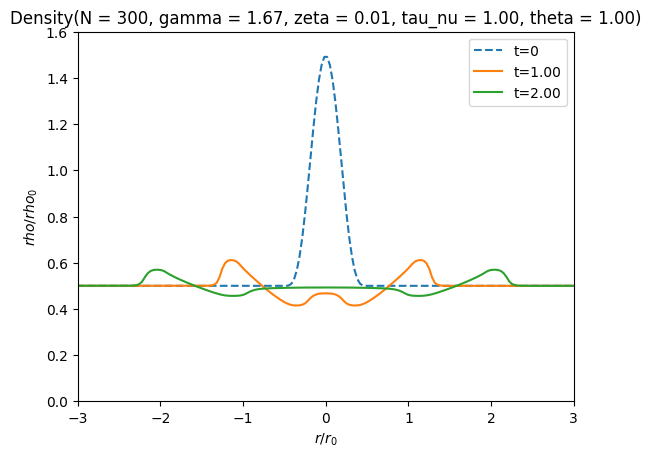

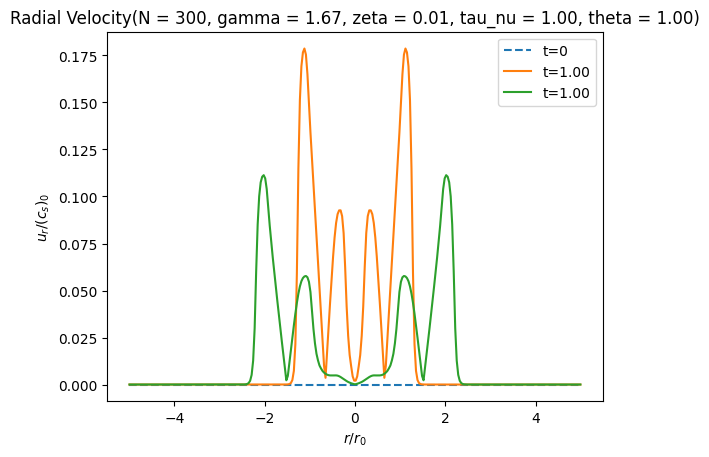

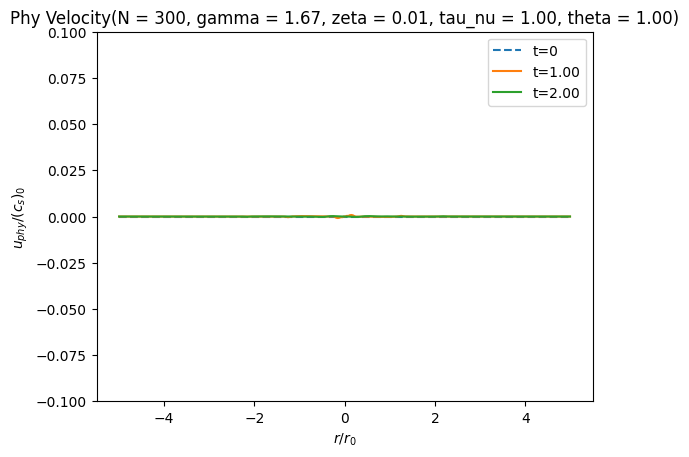

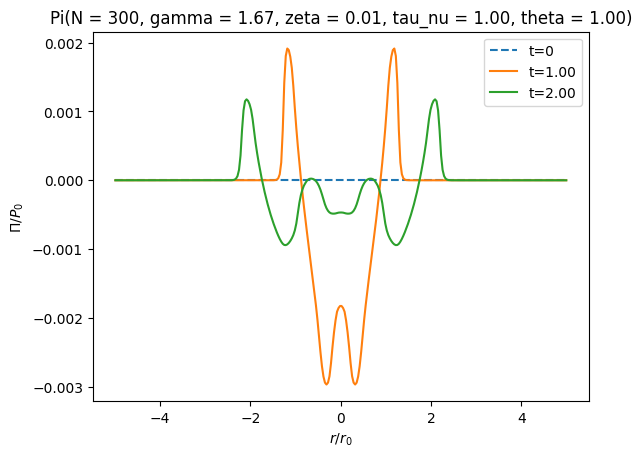

In [ ]:
i=100
j=200
print(len(solution))
rhoic = solution[0][:N][int(N/2)]
rho1 = solution[i][:N][int(N/2)]
rho1prime = solution[j][:N][int(N/2)]
rho2 = (solution[i][:N].T)[int(N/2)]

uxic = solution[0][N:2*N][int(N/2)]/rhoic
ux = solution[i][N:2*N][int(N/2)]/rho1
uxprime = solution[j][N:2*N][int(N/2)]/rho1prime

uyic = solution[0][2*N:3*N][int(N/2)]/rhoic
uy = solution[i][2*N:3*N][int(N/2)]/rho1
uyprime = solution[j][2*N:3*N][int(N/2)]/rho1prime

Piic = solution[0][3*N:][int(N/2)]
Pi = solution[i][3*N:][int(N/2)]
Piprime = solution[j][3*N:][int(N/2)]

uric =  np.sqrt(uxic**2 + uyic**2)
ur = np.sqrt(ux**2 + uy**2)
urprime = np.sqrt(uxprime**2 + uyprime**2)

uphyic = (X[:][int(N/2)]*uyic - Y[:][int(N/2)]*uxic)/(R[:][int(N/2)])
uphy = (X[:][int(N/2)]*uy - Y[:][int(N/2)]*ux)/(R[:][int(N/2)])
uphyprime = (X[:][int(N/2)]*uyprime - Y[:][int(N/2)]*uxprime)/(R[:][int(N/2)])


plt.ylim(0,1.6)
plt.xlim(-3,3)
plt.plot(xlin,rhoic, label='t=0', linestyle='dashed')
plt.plot(xlin,rho1, label='t={:.2f}'.format(i*tOut))
plt.plot(xlin,rho1prime, label='t={:.2f}'.format(j*tOut))
#plt.plot(xlin,rho2)
plt.xlabel(r'$r/r_0$')
plt.ylabel(r'$ \rho / \rho_{0}$')
plt.title(r'Density$(N = {}, \gamma = {:.2f}, \zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
plt.legend()
plt.show()

plt.plot(xlin,uric, label='t=0', linestyle='dashed')
plt.plot(xlin,ur,label='t={:.2f}'.format(i*tOut))
plt.plot(xlin,urprime,label='t={:.2f}'.format(i*tOut))
plt.xlabel(r'$r/r_0$')
plt.ylabel(r'$ u_r / (c_s)_{0}$')
plt.title(r'Radial Velocity$(N = {}, \gamma = {:.2f}, \zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
plt.legend()
plt.show()


plt.plot(xlin,uphyic, label='t=0', linestyle='dashed')
plt.plot(xlin,uphy, label='t={:.2f}'.format(i*tOut))
plt.plot(xlin,uphyprime, label='t={:.2f}'.format(j*tOut))
plt.ylim(-0.1,0.1)
plt.xlabel(r'$r/r_0$')
plt.ylabel(r'$ u_{phy} / (c_s)_{0}$')
plt.title(r'Phy Velocity$(N = {}, \gamma = {:.2f}, \zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
plt.legend()
plt.show()

plt.plot(xlin,Piic, label='t=0', linestyle='dashed')
plt.plot(xlin,Pi, label='t={:.2f}'.format(i*tOut))
plt.plot(xlin,Piprime, label='t={:.2f}'.format(j*tOut))
plt.xlabel(r'$r/r_0$')
plt.ylabel(r'$ \Pi / P_{0}$')
plt.title(r'$Pi(N = {}, \gamma = {:.2f}, \zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
plt.legend()
plt.show()

plt.plot(xlin,rhoic,label=r'$\rho_{inicial}/\rho_0$', linestyle='dashed')
plt.plot(xlin,rho1,label=r'$\rho/\rho_0$')
plt.plot(xlin,uric, label=r'$ur_{inicial}/(c_s)_0$', linestyle='dotted')
plt.plot(xlin,ur, label=r'$ur/(c_s)_0$')
plt.plot(xlin,Piic,label=r'$\Pi_{initial}/P_0$', linestyle = 'dashdot')
plt.plot(xlin,Pi,label=r'$\Pi/P_0$')
plt.title(r'$(N = {},\gamma = {:.2f}, \zeta = {:.2f}, \tau_\nu = {:.2f}, \theta = {:.2f})$'.format(N,gamma, zeta, tau_nu, theta))
plt.xlabel('$r/r_0$')
plt.legend()
plt.show()

In [ ]:
plt.plot(tOut*np.array(range(len(mass))),mass/mass[0])
plt.show()

In [ ]:
i=0

while i < len(solution):
  rho1 = solution[i][:N][int(N/2)]
  rho2 = (solution[i][:N].T)[int(N/2)]
  ux = solution[i][N:2*N][int(N/2)]
  uy = solution[i][2*N:3*N][int(N/2)]
  Pi = solution[i][3*N:][int(N/2)]
  ur = np.sqrt(ux**2 + uy**2)
  uphy = (X[:][int(N/2)]*uy - Y[:][int(N/2)]*ux)/(R[:][int(N/2)])
  #plt.ylim(-0.5,0.5)
  #plt.plot(xlin,uphy)
  #plt.show()




  plt.ylim(0.1,1.5)
  plt.plot(xlin,rho1)
  plt.show()
  i += 1




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Define Mesh 2
dx = boxsize / N   # box size
dy = dx
vol = dx**2        # volume of each box
xlin = np.linspace(-0.5*(boxsize-0.5*dx), 0.5*(boxsize-0.5*dx), N)# simulation limits
Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

rho = (1.2*(R <= 1*0.25*boxsize) + 1*(R > 1*0.25*boxsize))
vx = np.zeros(s)
vy = np.zeros(s)
Pi = np.zeros(s)
IC = np.vstack((rho, rho*vx, rho*vy, Pi))

solution, mass = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, 0.01, applyBC, args=(dx, dy, N, gamma, zeta, tau_nu, theta))